Project Members: Mudassir Hussain (sh7420), Abhignya Bhat (ayb5037), Anshika Gupta(ag8800) 

# SGD with learning rate =0.005 and 0.01
Our aim is to compare the performance by tweaking the learning rates. We are going to compare it with lr=0.005 and lr=0.01.

First, we need to add all the packages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import torch.backends.cudnn as cudnn
import sys
import time
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

Setting up the device to use cuda.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
valid_ratio = 0.9

Now we will do data augmentation using predetermined normalize parameters. We will then load training, test and valid dataset. We will also assign batch_size to the resnet iterator aka ..loader.

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_data = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=128, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

n_train_examples = int(len(train_data) * valid_ratio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = transform_test

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=128, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=128, shuffle=False, num_workers=2)

valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=128, shuffle=False)

# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12793669.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Test classes

In [4]:
classes = test_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Function to plot the images

In [5]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

Plotting 25 images from the training data with labels.

In [6]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

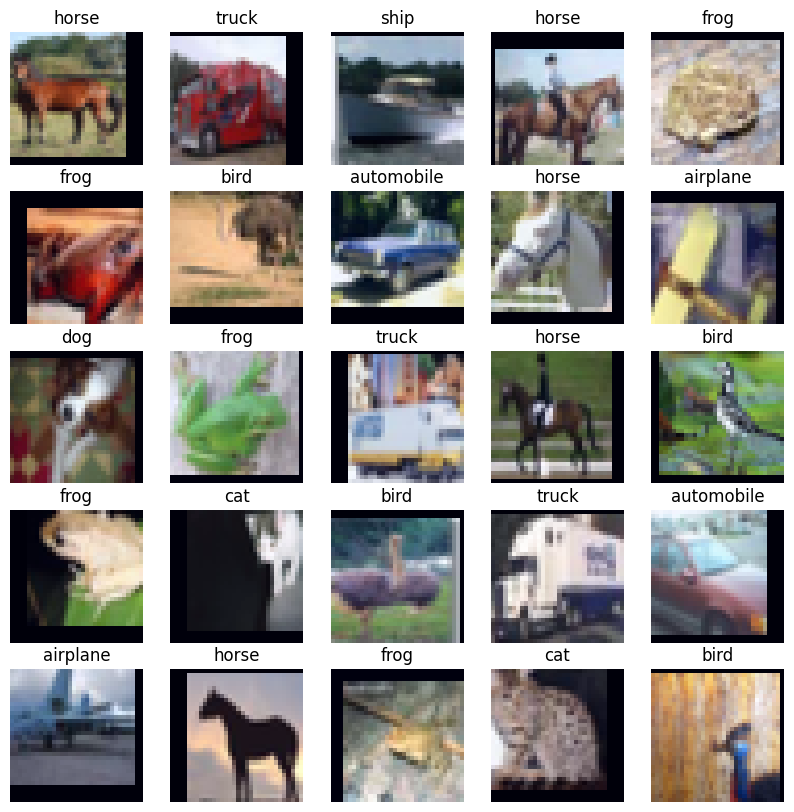

In [7]:
plot_images(images, labels, classes, normalize = True)

# **Building the model**
Ref: https://github.com/kuangliu/pytorch-cifar

We have used the above reference and made a few changes in the ResNet class so that we do not overshoot the parameters beyond 5 million.

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

As we can see, we have decided to go with 3 layers instead of 4. 

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self.x(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

This the method to initialize the ResNet18 model.

In [10]:
def ResNet18():
    return ResNet(BasicBlock, [3,2,3])

Inititalizing the model and loading it on to the device.

In [11]:
model = ResNet18()
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

Here, we calculate the total number of parameters, and making sure we are not exceeding 5 million.

In [12]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the model: ", num_params)

Total number of parameters in the model:  4032330


# SGD with learning rate=0.005.
Defining the optimizer and the learning rate, momentum, and weight.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

To calculate accuracy between y_pred and target.

In [14]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Using some code snippets from ref https://github.com/kuangliu/pytorch-cifar. We will be using three different methods. One for training, another for testing and the last one for validating.

In [15]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        acc = calculate_accuracy(y_pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += acc.item()
    return train_loss / len(train_loader), correct / len(train_loader)


In [16]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            correct += acc.item()
    return test_loss / len(test_loader), correct / len(test_loader)

    # Save checkpoint.
    acc_temp = 100.*correct/total
    if acc_temp > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc_temp,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc_temp


In [17]:
def validate(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            correct += acc.item()
    return test_loss / len(valid_loader), correct / len(valid_loader)

Here, we run it for 75 epoch. 

In [18]:
train_loss = []
test_loss = []
epoch = []
train_acc = []
test_acc=[]
#created the above lists to plot the graphs.

for e in range(start_epoch, start_epoch+75):
    train_epoch_loss, train_epoch_acc = train(e) #training the model
    vaild_epoch_loss, valid_epoch_acc = validate(e) #validating
    test_epoch_loss, test_epoch_acc = test(e) #evaluating the model
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_acc.append(test_epoch_acc)
    test_loss.append(test_epoch_loss)
    epoch.append(e)
    print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.3f}%')
    print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.3f}%')
    print(f'\t Test. Loss: {test_epoch_loss:.3f} |  Test. Acc: {test_epoch_acc*100:.3f}%')


Epoch: 0
	Train Loss: 1.439 | Train Acc: 47.101%
	 Val. Loss: 1.363 |  Val. Acc: 52.051%

Epoch: 1
	Train Loss: 0.933 | Train Acc: 66.921%
	 Val. Loss: 0.909 |  Val. Acc: 69.082%

Epoch: 2
	Train Loss: 0.732 | Train Acc: 74.258%
	 Val. Loss: 0.733 |  Val. Acc: 75.586%

Epoch: 3
	Train Loss: 0.613 | Train Acc: 78.650%
	 Val. Loss: 0.669 |  Val. Acc: 77.441%

Epoch: 4
	Train Loss: 0.541 | Train Acc: 81.296%
	 Val. Loss: 0.660 |  Val. Acc: 78.398%

Epoch: 5
	Train Loss: 0.489 | Train Acc: 83.075%
	 Val. Loss: 0.578 |  Val. Acc: 81.523%

Epoch: 6
	Train Loss: 0.439 | Train Acc: 84.948%
	 Val. Loss: 0.567 |  Val. Acc: 81.875%

Epoch: 7
	Train Loss: 0.396 | Train Acc: 86.466%
	 Val. Loss: 0.497 |  Val. Acc: 83.691%

Epoch: 8
	Train Loss: 0.367 | Train Acc: 87.270%
	 Val. Loss: 0.589 |  Val. Acc: 81.777%

Epoch: 9
	Train Loss: 0.340 | Train Acc: 88.224%
	 Val. Loss: 0.492 |  Val. Acc: 84.844%

Epoch: 10
	Train Loss: 0.324 | Train Acc: 88.748%
	 Val. Loss: 0.584 |  Val. Acc: 81.777%

Epoch: 1

**Plotiing Train loss vs Test Loss**

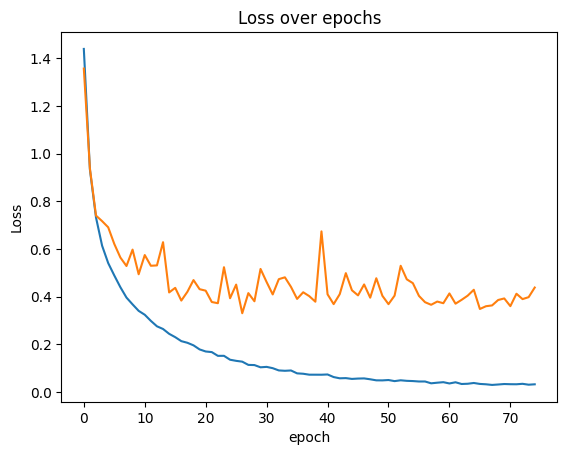

In [19]:
plt.plot(epoch, train_loss, label="train loss")
plt.plot(epoch,test_loss, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

**Plotting the train accuracy vs test accuracy**

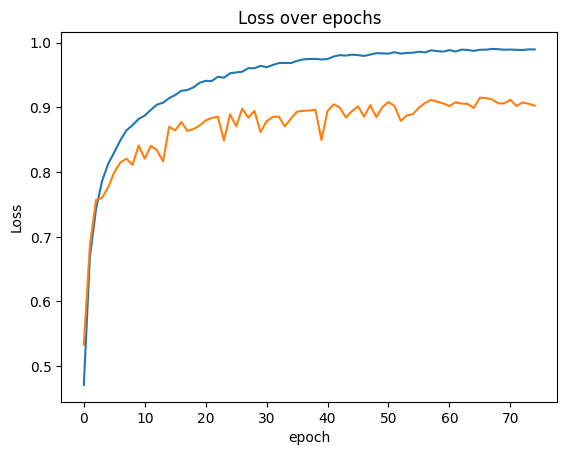

In [20]:
plt.plot(epoch, train_acc, label="train loss")
plt.plot(epoch, test_acc, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

This piece of code has been taken from HW, and the following code cells are used to plot the confusion matrix.

In [21]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            labels.append(y)
            probs.append(y_pred)
            
   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [22]:
labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [23]:
def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

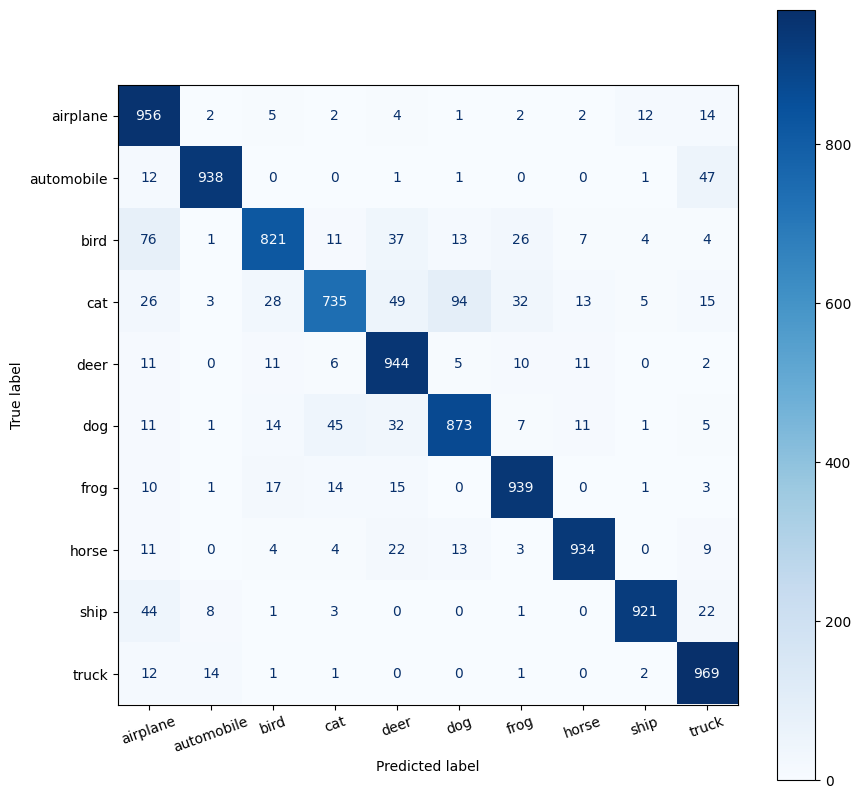

In [24]:
labels = labels.to("cpu")
pred_labels = pred_labels.to("cpu")
plot_confusion_matrix(labels, pred_labels, classes) 

# **SGD with lr = 0.01**

For this section, we need to initialize new model, updated optimizer with new learning rate=0.01.

In [25]:
new_model = ResNet18()
new_model = new_model.to(device)
if device == 'cuda':
    new_model = torch.nn.DataParallel(new_model)
    cudnn.benchmark = True

In [26]:
num_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
print("Total number of parameters in the model: ", num_params)

Total number of parameters in the model:  4032330


In [27]:
criterion = nn.CrossEntropyLoss()
updated_optimizer = optim.SGD(new_model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4) #learning rate=0.01
updated_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(updated_optimizer, T_max=200)

Changes with respect to new model and updated optimizer.

In [28]:
def updated_train(epoch):
    print('\nEpoch: %d' % epoch)
    new_model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        updated_optimizer.zero_grad()
        y_pred = new_model(inputs)
        loss = criterion(y_pred, targets)
        acc = calculate_accuracy(y_pred, targets)
        loss.backward()
        updated_optimizer.step()
        train_loss += loss.item()
        correct += acc.item()
    return train_loss / len(train_loader), correct / len(train_loader)

In [29]:
def updated_test(epoch):
    global best_acc
    new_model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = new_model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            correct += acc.item()
    return test_loss / len(test_loader), correct / len(test_loader)

In [30]:
def updated_validate(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = new_model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets)
            test_loss += loss.item()
            # _, predicted = outputs.max(1)
            # total += targets.size(0)
            correct += acc.item()
    return test_loss / len(valid_loader), correct / len(valid_loader)

Again, running the training, validate, testing methods in the new model.

In [31]:
new_train_loss = []
new_test_loss = []
new_epoch = []
new_train_acc = []
new_test_acc = []


for e in range(start_epoch, start_epoch+75):
    train_epoch_loss, train_epoch_acc = updated_train(e)
    vaild_epoch_loss, valid_epoch_acc = updated_validate(e)
    test_epoch_loss, test_epoch_acc = updated_test(e)
    new_train_loss.append(train_epoch_loss)
    new_train_acc.append(train_epoch_acc)
    new_test_acc.append(test_epoch_acc)
    new_test_loss.append(test_epoch_loss)
    new_epoch.append(e)
    print(f'\tTrain Loss: {train_epoch_loss:.3f} | Train Acc: {train_epoch_acc*100:.3f}%')
    print(f'\t Val. Loss: {vaild_epoch_loss:.3f} |  Val. Acc: {valid_epoch_acc*100:.3f}%')
    print(f'\t Test. Loss: {test_epoch_loss:.3f} |  Test. Acc: {test_epoch_acc*100:.3f}%')


Epoch: 0
	Train Loss: 1.424 | Train Acc: 47.451%
	 Val. Loss: 1.143 |  Val. Acc: 59.062%

Epoch: 1
	Train Loss: 0.922 | Train Acc: 67.239%
	 Val. Loss: 0.852 |  Val. Acc: 69.961%

Epoch: 2
	Train Loss: 0.709 | Train Acc: 75.081%
	 Val. Loss: 0.712 |  Val. Acc: 74.863%

Epoch: 3
	Train Loss: 0.608 | Train Acc: 78.678%
	 Val. Loss: 0.603 |  Val. Acc: 79.258%

Epoch: 4
	Train Loss: 0.525 | Train Acc: 81.970%
	 Val. Loss: 0.580 |  Val. Acc: 80.332%

Epoch: 5
	Train Loss: 0.470 | Train Acc: 83.602%
	 Val. Loss: 0.506 |  Val. Acc: 82.109%

Epoch: 6
	Train Loss: 0.423 | Train Acc: 85.504%
	 Val. Loss: 0.478 |  Val. Acc: 83.887%

Epoch: 7
	Train Loss: 0.388 | Train Acc: 86.569%
	 Val. Loss: 0.490 |  Val. Acc: 83.809%

Epoch: 8
	Train Loss: 0.359 | Train Acc: 87.523%
	 Val. Loss: 0.445 |  Val. Acc: 84.902%

Epoch: 9
	Train Loss: 0.333 | Train Acc: 88.514%
	 Val. Loss: 0.429 |  Val. Acc: 85.820%

Epoch: 10
	Train Loss: 0.311 | Train Acc: 89.235%
	 Val. Loss: 0.418 |  Val. Acc: 86.074%

Epoch: 1

**Plotting Train loss and test loss for the new model**

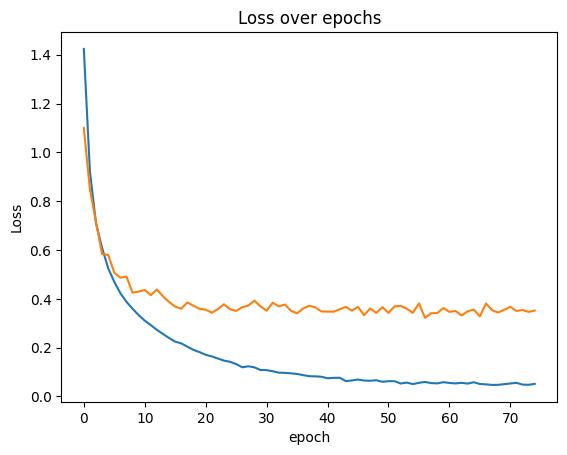

In [32]:
plt.plot(epoch, new_train_loss, label="train loss")
plt.plot(epoch, new_test_loss, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

**Plotting Train accuracy and test accuracy for the new model**

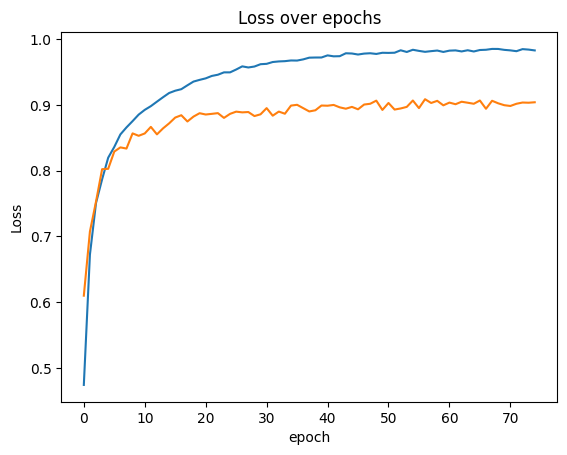

In [33]:
plt.plot(epoch, new_train_acc, label="train loss")
plt.plot(epoch, new_test_acc, label="test loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.show()

**Plotting confusion matrix for the new model.**

In [34]:
new_labels, new_probs = get_predictions(new_model, test_loader, device)
new_pred_labels = torch.argmax(new_probs, 1)

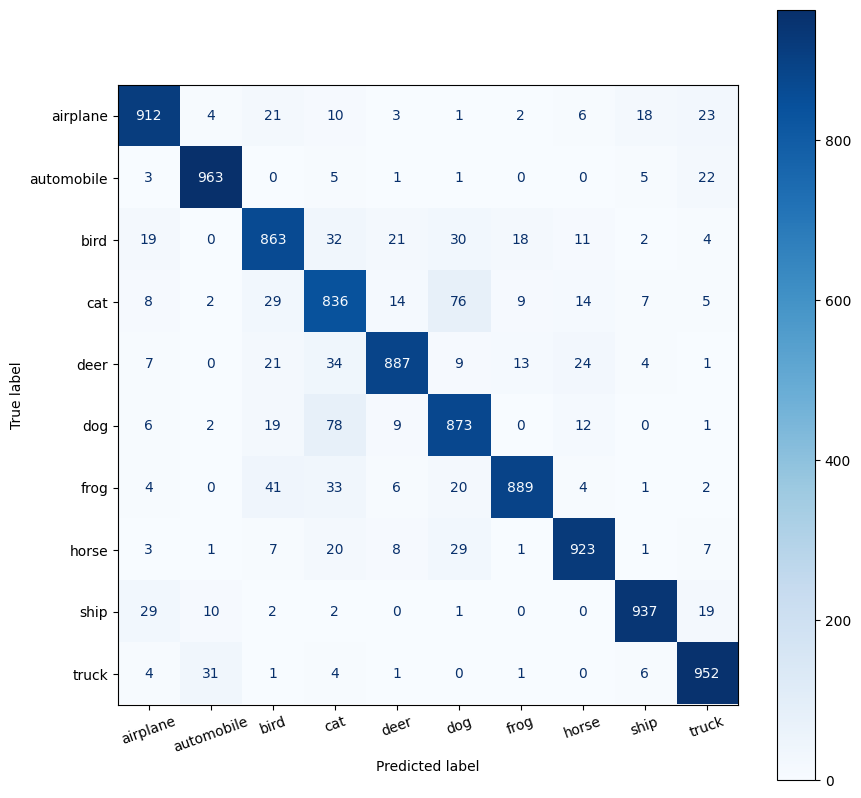

In [35]:
new_labels = new_labels.to("cpu")
new_pred_labels = new_pred_labels.to("cpu")
plot_confusion_matrix(new_labels, new_pred_labels, classes) 

**Now, we plot graph to compare the Test acc with respect to lr=0.005 and lr=0.01. Also, we will compare Test loss with respect to  lr=0.005 and lr=0.01**

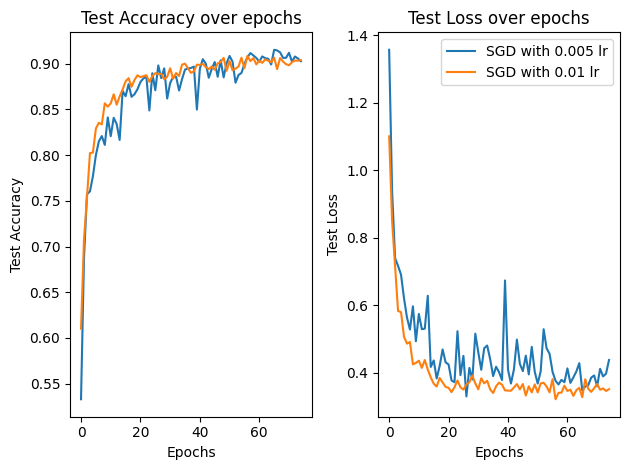

In [37]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(epoch,test_acc, label="SGD with 0.005 lr")
axes[0].plot(epoch,new_test_acc,label="SGD with 0.01 lr")
plt.legend()
axes[0].set_title('Test Accuracy over epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Test Accuracy')

# Plot the second graph on the right subplot
axes[1].plot(epoch,test_loss, label="SGD with 0.005 lr")
axes[1].plot(epoch,new_test_loss, label="SGD with 0.01 lr")
plt.legend()
axes[1].set_title('Test Loss over epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Test Loss')
# Adjus
# Adjust the layout to prevent overlapping of titles and labels
plt.tight_layout()

# Show the plots
plt.show()